## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from tensorflow_probability import edward2 as ed
%matplotlib inline

/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) 

/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.7/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.7/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.7/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be unders

# Configuration

Now we define the learning method, whether there will be or not model miss-specification and the number of models of the ensemble.



In [2]:
## Learning Method
# 0. MAP Learning 
# 2. PAC$^2$-Ensemble Learning
# 3. PAC$^2_T$-Ensemble Learning

LEARNING_METHOD = 3

## Control the presence of model miss-specficication as shown in Figures 2 and 3. 
MODEL_MISSSPECIFICATION = True

## Number of ensemble models.
K=3

# Data Set

In this first part, we present the data set used for this example. By setting the flag ``MODEL_MISSSPECIFICATION`` we can generate the figures under perfect model specification or under model miss-specification. 

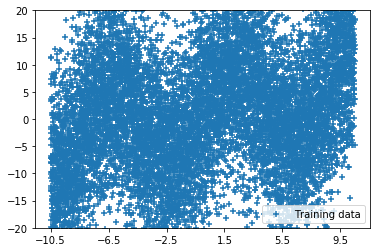

In [3]:
# Set seeds for reproducibility
np.random.seed(0)
tf.set_random_seed(1)

if MODEL_MISSSPECIFICATION:
    VAR=10.
else:
    VAR=1.

NSAMPLE = 10000
def sampleData(samples, variance):
    x = np.linspace(-10.5, 10.5, samples).reshape(-1, 1)
    r = 1+np.float32(np.random.normal(size=(samples,1),scale=variance))
    y = np.float32(np.sin(0.75*x)*7.0+x*0.5+r*1.0)
    return (x,y)

(x_train, y_train) = sampleData(NSAMPLE, VAR)
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.ylim(-20,20)
plt.xticks(np.arange(-10.5, 10.5, 4))
plt.legend()
plt.show()

# Learning a Neural Network

We now employ Tensorflow Probability and Edward 2 to define and make varitional inference over a Bayesian neural network. 

In [4]:
NHIDDEN = 20

x = tf.placeholder("float", shape=[None, 1])
y = tf.placeholder("float", shape=[None, 1])

def model(NHIDDEN, x):
    W = tf.Variable(tf.random_normal([1, NHIDDEN], 0.0, 0.05, dtype=tf.float32))
    b = tf.Variable(tf.random_normal([1, NHIDDEN], 0.0, 0.05, dtype=tf.float32))

    W_out = tf.Variable(tf.random_normal([NHIDDEN, 1], 0.0, 0.05, dtype=tf.float32))
    b_out = tf.Variable(tf.random_normal([1, 1], 0.0, 0.05, dtype=tf.float32))

    hidden_layer = tf.nn.tanh(tf.matmul(x, W) + b)
    out = tf.matmul(hidden_layer, W_out) + b_out
    y = ed.Normal(loc=out, scale=1.0, name="y")

    return x, y


t = []
tpy = []
for i in range(K):
    px,py = model(NHIDDEN,x)
    t.append(py.distribution.log_prob(y))
    tpy.append(py)

## Defining the variational functionals

And, now, we define the functionals $\bar{\cal L}_{PB^2}(\rho)$ and $\bar{\cal L}_{PB^2_h}(\rho)$ for computing the posterior $\rho(\theta|D)$ and $\rho_h(\theta|D)$, respectively.

In [5]:
probs = tf.math.softmax(tf.Variable(tf.ones([K], dtype=tf.float32), trainable=False, name='probs'))


ensemble = tf.concat(t,1)
logmax = tf.stop_gradient(tf.math.reduce_max(ensemble,axis=1))
logmean = tf.stop_gradient(tf.math.reduce_logsumexp(ensemble+tf.reshape(tf.tile(tf.log(probs),[NSAMPLE]),[NSAMPLE,K]), axis=1) - tf.log(K + 0.0))
varlist = []

#####
inc = logmean-logmax
if (LEARNING_METHOD==3):
    hmax = 2*tf.stop_gradient(inc/tf.math.pow(1-tf.math.exp(inc),2) + tf.math.pow(tf.math.exp(inc)*(1-tf.math.exp(inc)),-1))
else:
    hmax = 1.
#####


for i in range(K):
    vari = 0.5*(tf.reduce_sum(tf.exp(2*ensemble[:,i]-2*logmax)*hmax,axis=0))
    for j in range(K):
        vari = vari - 0.5*tf.reduce_sum(tf.reduce_sum(tf.exp(ensemble[:,i] + ensemble[:,j] - 2*logmax)*hmax,axis=0))*probs[j]
    varlist.append(vari)

var=tf.stack(varlist,0)
dataenergy = tf.reduce_sum(ensemble,axis=0)

if (LEARNING_METHOD==2 or LEARNING_METHOD==3):
    elboEnsemble = dataenergy + var
else:
    elboEnsemble = dataenergy
    
pacelbo = tf.reduce_sum(tf.math.multiply(elboEnsemble,probs))

pacelbo = pacelbo - tf.reduce_sum(tf.math.multiply(probs,tf.log(probs)))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Optimizing the variational functionals

We perform gradient-based optimization of the above objective. 

In [6]:
num_epochs=5000
verbose=True
sess = tf.Session()
t = []
train =  tf.train.AdamOptimizer(0.01).minimize(-pacelbo)
init = tf.global_variables_initializer()
sess.run(init)

for i in range(num_epochs+1):
    t.append(-sess.run(pacelbo,feed_dict={x: x_train,y: y_train}))
    sess.run(train,feed_dict={x: x_train,y: y_train})
    if verbose:
        if i % 100 == 0:
            str_elbo = str(-t[-1])
            print("\n" + str(i) + " epochs\t" + str_elbo, end="", flush=True)



0 epochs	-673327.94


100 epochs	-845550.44


200 epochs	-870264.44


300 epochs	-866744.56


400 epochs	-863677.3


500 epochs	-861310.6


600 epochs	-859747.44


700 epochs	-858619.44


800 epochs	-857947.06


900 epochs	-853809.2


1000 epochs	-845519.75


1100 epochs	-828202.06


1200 epochs	-817881.7


1300 epochs	-810897.44


1400 epochs	-803133.7


1500 epochs	-797332.7


1600 epochs	-790176.7


1700 epochs	-778222.25


1800 epochs	-768747.7


1900 epochs	-762240.25


2000 epochs	-751403.0


2100 epochs	-741520.06


2200 epochs	-729302.25


2300 epochs	-720277.9


2400 epochs	-715692.7


2500 epochs	-713277.4


2600 epochs	-712079.3


2700 epochs	-711463.1


2800 epochs	-711481.8


2900 epochs	-711341.9


3000 epochs	-711392.4


3100 epochs	-711283.3


3200 epochs	-711229.5


3300 epochs	-711228.2


3400 epochs	-711200.06


3500 epochs	-711194.44


3600 epochs	-711128.94


3700 epochs	-711088.75


3800 epochs	-711072.3


3900 epochs	-711087.9


4000 epochs	-711026.3


4100 epochs	-710976.94


4200 epochs	-710943.44


4300 epochs	-710916.5


4400 epochs	-710832.7


4500 epochs	-710896.3


4600 epochs	-710855.56


4700 epochs	-710873.75


4800 epochs	-710798.2


4900 epochs	-710777.1


5000 epochs	-710718.7

## Evaluating the learned model
Once the model is learned, we evaluate how it makes predictions by ploting its associated epistemic and aleatoric uncertainty

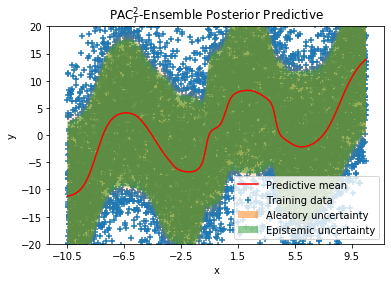

In [7]:
NSAMPLETEST = 10000
(x_test, y_test) = sampleData(NSAMPLETEST, VAR)

y_pred_list = []
y_pred_noise = []

for i in range(K):
    [mean, noise] = sess.run([tpy[i].distribution.mean(), tpy[i]], feed_dict={x: x_test})
    y_pred_list.append(mean)
    y_pred_noise.append(noise)

y_preds = np.concatenate(y_pred_list, axis=1)
y_preds_noise = np.concatenate(y_pred_noise, axis=1)

w = sess.run(probs)
y_mean = np.average(y_preds, weights = w, axis=1)
y_sigma = np.sqrt(np.average(np.power(y_preds,2), weights = w, axis=1) - y_mean**2)

y_mean_noise = np.average(y_preds_noise, weights = w, axis=1)
y_sigma_noise = np.sqrt(np.average(np.power(y_preds_noise,2), weights = w, axis=1) - y_mean_noise**2)

plt.plot(x_test, y_mean.reshape(-1, 1), 'r-', label='Predictive mean');
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.fill_between(x_test.ravel(),
                 y_mean + 2 * y_sigma_noise,
                 y_mean - 2 * y_sigma_noise,
                 alpha=0.5, label='Aleatory uncertainty')

plt.fill_between(x_test.ravel(),
                 y_mean + 2 * y_sigma,
                 y_mean - 2 * y_sigma,
                 alpha=0.5, label='Epistemic uncertainty')


plt.ylabel('y')
plt.xlabel('x')
plt.ylim(-20,20)
#plt.xticks(np.arange(-20., 20.5, 4))
plt.xticks(np.arange(-10.5, 10.5, 4))
plt.legend();


dataname = 'Sindata'

if (LEARNING_METHOD==3):
    plt.title(r'PAC$^2_T$-Ensemble Posterior Predictive')
elif (LEARNING_METHOD==2):
    plt.title(r'PAC$^2$-Ensemble Posterior Predictive')
else:
    plt.title(r'(MAP)-Ensemble Posterior Predictive')

plt.show()


Let's have a look at the indivual models of the ensemble.

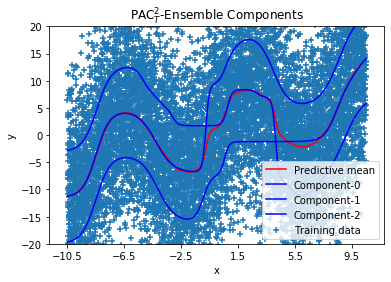

In [8]:

#plt.figure(figsize=(8, 8))
plt.plot(x_test, y_mean.reshape(-1, 1), 'r-', label='Predictive mean');
plt.scatter(x_train, y_train, marker='+', label='Training data')

for i in range(K):
    plt.plot(x_test, y_preds[:,i], 'b-',label='Component-'+str(i));

plt.ylabel('y')
plt.xlabel('x')
plt.ylim(-20,20)
#plt.xticks(np.arange(-20., 20.5, 4))
plt.xticks(np.arange(-10.5, 10.5, 4))
plt.legend();

if (LEARNING_METHOD==3):
    plt.title(r'PAC$^2_T$-Ensemble Components')
elif (LEARNING_METHOD==2):
    plt.title(r'PAC$^2$-Ensemble Components')
else:
    plt.title(r'(MAP)-Ensemble Components')

plt.show()


We also compute the *log-likelihood of the predicitive posterior* over the independent test data set.

In [9]:
y_pred_list = []
for i in range(K):
    y_pred_list.append(tpy[i].distribution.log_prob(y_test)+tf.log(probs[i]))

y_preds = tf.concat(y_pred_list, axis=1)

score = tf.reduce_sum(tf.math.reduce_logsumexp(y_preds,axis=1)-tf.log(K+0.0))

score = sess.run(score,feed_dict={x: x_test})

print("\n Negative Log-likelihood of the posterior predictive : "+str(score))


 Negative Log-likelihood of the posterior predictive : -158792.83
